In [1]:
# import packages
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:

# Camera calibration class - image distortion - Chessboard
class CalibrateCamera:
    # nx = number of inside corners in x
    # ny = number of inside corners in y
    # path = path to chessboard images
    def __init__(self, nx, ny, path):
        self.images = glob.glob(path)
        self.nx = nx
        self.ny = ny
        self.objpoints = []
        self.imgpoints = []
        self.toDraw = []
        
        # Prepare object points, like (0,0,0),(1,0,0),(2,0,0)....,(8,5,0).
        objp = np.zeros((nx*ny,3), np.float32)
        objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) # x, y coordinates
        #objp = np.zeros((6*9,3), np.float32)
        #objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) # x, y coordinates
        
        print('WAIT... ...')
        for fname in self.images:
            # read in image.
            img = cv2.imread(fname)

            # Convert to grayscale.
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Find the chessboard corners.
            ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

            # If cormers found, add object points, image points.
            if ret == True:
                self.imgpoints.append(corners)
                self.objpoints.append(objp)
                self.toDraw.append([img, (nx, ny), corners, ret])

        # dist = distortion coefficients and mtx = camera matrix
        # rvecs = rotation vector and tvecs = translation vector        
        self.ret, self.mtx, self.dist, self.rvecs, self.tvecs = cv2.calibrateCamera(self.objpoints, self.imgpoints, gray.shape[::-1],None,None)
        print('{} images had corners found and were used for camera calibration'.format(len(self.imgpoints)))
        print('undistortImage ready to accept images!')
        
        
    def undistortImage(self, image):
        return cv2.undistort(image, self.mtx, self.dist, None, self.mtx)
        
    def getDrawArray(self):
        return self.toDraw
        


In [3]:
def abs_sobel_thresh(img, orient='x', thresh=(0,255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)#cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output


# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)#cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output


# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)# cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output


# Define a function that thresholds the S-channel of HLS
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)# cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

# Combines gradient and color thresholds apllied to an image
def get_binary_image(image):
    # Choose a Sobel kernel size
    #ksize = 9 
    ksize = 3

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', thresh=(35, 255))
    grady = abs_sobel_thresh(image, orient='y', thresh=(45, 90))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(25, 160))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.2))
    #hls_binary = hls_select(image, thresh=(165, 255))
    hls_binary = hls_select(image, thresh=(125, 255))
    
    combined = np.zeros_like(hls_binary)
    #combined[((gradx == 1) & (grady == 1) | (hls_binary == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 255
    
    combined[((gradx == 1) & (mag_binary == 1) & (dir_binary == 1)) | ((gradx == 1) & (grady == 1)) | (hls_binary == 1)] = 1
    return combined


# Only keeps the region of the image defined by the polygon
# formed from `vertices`. The rest of the image is set to black.
#### NOT USED ####
def region_of_interest(img, vertices):

    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


In [4]:
# Warp image to birdeye view and back
def warp(img, src, dst):
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))
    return warped

# Calculate slope of the line
def check_slope_of_line(px1, px2):
    x1, x2 = px1[0], px2[0]
    y1, y2 = px1[1], px2[1]
    return (y2 - y1) / (x2 - x1)

# Find radius of curvature for the line
def find_radius_of_curvature(ploty, xarr):
    
    x = xarr[::-1]  # Reverse to match top-to-bottom in y

    # Fit a second order polynomial to pixel positions in lane line
    fit = np.polyfit(ploty, x, 2)
    fitx = fit[0]*ploty**2 + fit[1]*ploty + fit[2]

    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    ev = np.max(ploty)
    curverad = ((1 + (2*fit[0]*ev + fit[1])**2)**1.5) / np.absolute(2*fit[0])

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    fit_cr = np.polyfit(ploty*ym_per_pix, x*xm_per_pix, 2)

    # Calculate the new radi of curvature
    curverad = ((1 + (2*fit_cr[0]*ev*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
    
    # Now our radius of curvature is in meters
    #line.radius_of_curvature = curverad
    return curverad
    

# Calculate pixel distance in meters for the line from center of the camera
def calculate_distance_to_center(px, imageShape):
    xm_per_pix = 3.7 / 700 # meters per pixel in x dimension

    middle = imageShape[1] / 2
    
    # Calculate distance to middle of image
    pixelDistance = abs(middle - px)
    metersDistance = round(xm_per_pix * pixelDistance, 2)  

    return metersDistance

# Calculate car offset from mid of the lane
def offset_from_mid(leftDistance, rightDistance):
    disstr = ''
    if leftDistance < rightDistance:
        disstr = 'Lane offset from camera mid: {0:0.3f} m to right'.format(rightDistance - leftDistance)
    elif leftDistance > rightDistance:
        disstr = 'Lane offset from camera mid: {0:0.3f} m to left'.format(leftDistance - rightDistance)
    else:
        disstr = 'Lane offset from camera mid: Approx none'
    
    return disstr

# Create text to put into the image
def get_world_info(left_line, right_line, bimg):
    
    curvstr = ''
    if left_line.radius_of_curvature > 1800:
        curvstr = 'Radius of curvature: Approx None -> Straight'
    else:
        curvstr = 'Radius of curvature: {0:0.1f} m'.format(left_line.radius_of_curvature)
    
    # Write some Text
    cv2.putText(bimg, curvstr, (10,30), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,0),2)
    cv2.putText(bimg, offset_from_mid(left_line.line_base_pos, right_line.line_base_pos), (10,60), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,0),2)
    return bimg





In [5]:

class Line:
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = []    
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = []
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        # slope of line
        self.slope = 0

def sliding_window_search(binary_warped, left_line, right_line):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2)
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2)
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Set slope of line
    if len(leftx) > 0:
        l = len(leftx) / 2
        left_line.slope = check_slope_of_line([leftx[0], lefty[0]], [leftx[l], lefty[l]])
        
    if len(rightx) > 0:
        r = len(rightx) / 2
        right_line.slope = check_slope_of_line([rightx[0], righty[0]], [rightx[r], righty[r]])

    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    left_line.detected = True
    right_line.detected = True
    
    return out_img, left_fit, right_fit
    
    
    
def prev_window_check(binary_warped, left_line, right_line):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    
    left_fit = left_line.current_fit
    right_fit = right_line.current_fit
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Set slope of line
    if len(leftx) > 0:
        l = len(leftx) / 2
        left_line.slope = check_slope_of_line([leftx[0], lefty[0]], [leftx[l], lefty[l]])
        
    if len(rightx) > 0:
        r = len(rightx) / 2
        right_line.slope = check_slope_of_line([rightx[0], righty[0]], [rightx[r], righty[r]])

    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    
    # Fit a second order polynomial to each
    #print(left_fit)
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return out_img, left_fit, right_fit
    
def add_good_line(left_line, right_line, left_fit, right_fit, ploty):
    left_line.current_fit = left_fit
    right_line.current_fit = right_fit
    
    # Generate x and y values for plotting
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    if len(left_line.bestx) > 12:
        left_line.bestx.pop(0)    
    if len(left_line.recent_xfitted) > 12:
        left_line.recent_xfitted.pop(0)   
    left_line.bestx.append(left_fitx)
    left_line.recent_xfitted.append(left_fit)
    
    if len(right_line.bestx) > 12:
        right_line.bestx.pop(0)
    if len(right_line.recent_xfitted) > 12:
        right_line.recent_xfitted.pop(0)
    
    right_line.bestx.append(right_fitx)
    right_line.recent_xfitted.append(right_fit)

    left_line.allx, left_line.ally = left_fitx, ploty
    right_line.allx, right_line.ally = right_fitx, ploty

    
def find_lane_lines(binary_warped, left_line, right_line):
    ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
    # First lets find lines with either blind search or known window
    if left_line.detected == True:
        res, left_fit, right_fit = prev_window_check(binary_warped, left_line, right_line)
        # check slope of current fit throw away lines if slope is not within 25%
        if (abs(left_line.slope) - abs(right_line.slope) / abs(left_line.slope)) > 0.25:
            left_line.detected = False
        elif (abs(left_line.slope) - abs(right_line.slope) / abs(left_line.slope)) < -0.25:
            left_line.detected = False
        else:
            add_good_line(left_line, right_line, left_fit, right_fit, ploty)
    
    else:
        res, left_fit, right_fit = sliding_window_search(binary_warped, left_line, right_line)
        add_good_line(left_line, right_line, left_fit, right_fit, ploty)
    
    if len(left_line.recent_xfitted) > 3:
        # Smooth the output with average over last n frames. MAX 12
        # Left line
        sqleft = np.squeeze(left_line.bestx)
        avgleft = np.zeros((720))
        avgleft = sum(sqleft) / len(left_line.bestx)

        #left_line.current_fit = avgleft
        left_line.allx, left_line.ally = avgleft, ploty

        # Right line
        sqright = np.squeeze(right_line.bestx)
        avgright = np.zeros((720))
        avgright = sum(sqright) / len(right_line.bestx)
        
        #right_line.current_fit = avgright
        right_line.allx, right_line.ally = avgright, ploty

      
    # Set some info to Line Object
    # find and set curvature
    left_line.radius_of_curvature = find_radius_of_curvature(left_line.ally, left_line.allx)
    right_line.radius_of_curvature = find_radius_of_curvature(right_line.ally, right_line.allx)
    
    # A little sanity check set blind search again if radius of curvature is a bit off between lines
    if abs(left_line.radius_of_curvature - right_line.radius_of_curvature) > 100:
        left_line.detected = False
        right_line.detected = False
    
    # Add meters from lane to mid line to line object
    left_line.line_base_pos = calculate_distance_to_center(left_line.allx[-1], [720, 1280, 3])
    right_line.line_base_pos = calculate_distance_to_center(right_line.allx[-1], [720, 1280, 3])
    
    return res


    
def draw_lane(img, left_line, right_line):
    """ draw lane lines & current driving space """

    left_fitx, right_fitx = left_line.allx, right_line.allx
    ploty = left_line.ally
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(img).astype(np.uint8)
    color_warp = np.zeros_like(warp_zero)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    result = cv2.addWeighted(img, 1, warp_zero, 0.3, 0)
    return result, color_warp
    



In [6]:
# Main pipeline for the project
left = Line() # Global left line object
right = Line() # Global right line object

def pipeline(pic):
    # Global lines
    global left, right
    
    # Warp points
    src = np.float32([(249, 683),(590, 450),(690, 450),(1031, 683)])
    dst = np.float32([(320,720),(320, 0),(960, 0),(960, 720)])
    
    # prepare image to bird eye view
    undistorted_pic = cal.undistortImage(pic)
    binaryimg = get_binary_image(undistorted_pic)
    bin_warped = warp(binaryimg, src, dst)
    
    # Find lines and warp the birdeye view drawing back into original undistorted image
    lines = find_lane_lines(bin_warped, left, right)
    res, color_lane = draw_lane(lines, left, right)
    clr_img = warp(color_lane, dst, src)
    # Combine the result with the undistorted image
    result = cv2.addWeighted(undistorted_pic, 1, clr_img, 0.3, 0)
    
    # Add info to image
    bimg = get_world_info(left, right, np.zeros_like(result).astype(np.uint8))
    result = cv2.addWeighted(result, 1, bimg, 0.3, 0)

    return result
    



### 

In [7]:
cal = CalibrateCamera(9, 6, 'camera_cal/calibration*.jpg')
toDraw = cal.getDrawArray()


WAIT... ...
17 images had corners found and were used for camera calibration
undistortImage ready to accept images!


In [ ]:
# Draw the images and display the corners
print('Here we show how the corners are detected on the chessboard images used for calibration of the camera')
fig = plt.figure(figsize=(20, 10))
plt.subplot(2,3,1)
img1 = cv2.drawChessboardCorners(toDraw[0][0], toDraw[0][1], toDraw[0][2], toDraw[0][3])
plt.imshow(img1)
plt.subplot(2,3,2)
img2 = cv2.drawChessboardCorners(toDraw[3][0], toDraw[3][1], toDraw[3][2], toDraw[3][3])
plt.imshow(img2)
plt.subplot(2,3,3)
img3 = cv2.drawChessboardCorners(toDraw[6][0], toDraw[6][1], toDraw[6][2], toDraw[6][3])
plt.imshow(img3)
plt.subplot(2,3,4)
img4 = cv2.drawChessboardCorners(toDraw[9][0], toDraw[9][1], toDraw[9][2], toDraw[9][3])
plt.imshow(img4)
plt.subplot(2,3,5)
img5 = cv2.drawChessboardCorners(toDraw[12][0], toDraw[12][1], toDraw[12][2], toDraw[12][3])
plt.imshow(img5)
plt.subplot(2,3,6)
img6 = cv2.drawChessboardCorners(toDraw[15][0], toDraw[15][1], toDraw[15][2], toDraw[15][3])
plt.imshow(img6)
plt.tight_layout()
plt.savefig('chessboard_corners.png')

In [ ]:
# Test undistort chessboard images

img1 = cv2.imread('camera_cal/calibration1.jpg', cv2.COLOR_BGR2GRAY)
img2 = cv2.imread('camera_cal/calibration2.jpg', cv2.COLOR_BGR2GRAY)
undistortedimg1 = cal.undistortImage(img1)
undistortedimg2 = cal.undistortImage(img2)

print('Here we show example of chessboard images before and after undistort')
fig = plt.figure(figsize=(20, 10))
plt.subplot(2,2,1, title='Distorted image 1')
plt.imshow(img1)
plt.subplot(2,2,2, title='Undistorted image 1')
plt.imshow(undistortedimg1)
plt.subplot(2,2,3, title='Distorted image 2')
plt.imshow(img2)
plt.subplot(2,2,4, title='Undistorted image 2')
plt.imshow(undistortedimg2)
plt.tight_layout()
plt.savefig('distortedToUndistortedCB.png')

In [ ]:
# Test undistort on test images

img1 = cv2.imread('test_images/straight_lines1.jpg')#, cv2.COLOR_BGR2RGB)
img2 = cv2.imread('test_images/test6.jpg')#, cv2.COLOR_BGR2RGB)
undistortedimg1 = cal.undistortImage(img1)
undistortedimg2 = cal.undistortImage(img2)

print('Here we show example of chessboard images before and after undistort')
fig = plt.figure(figsize=(20, 10))
plt.subplot(2,2,1, title='Distorted image 1')
plt.imshow(img1)
plt.subplot(2,2,2, title='Undistorted image 1')
plt.imshow(undistortedimg1)
plt.subplot(2,2,3, title='Distorted image 2')
plt.imshow(img2)
plt.subplot(2,2,4, title='Undistorted image 2')
plt.imshow(undistortedimg2)
plt.tight_layout()
plt.savefig('distortedToUndistortedIMG.png')

In [ ]:
# Find warping points:
# I start by manually select points i feel are in middle of lines
# Then calculate pixel distance from those points to middle line
# And offset the points by distance from the middle line. 
# The distance from middle line is pixels between points / 2

img = cv2.imread('test_images/straight_lines2.jpg')#, cv2.COLOR_BGR2RGB)
#img = cv2.imread('test_images/test6.jpg', cv2.COLOR_BGR2RGB)

print('Draw in point to warp to birds eye view')
print('Blue points are warping points')
fig = plt.figure(figsize=(20, 10))
plt.imshow(cal.undistortImage(img))

# Draw manual points
plt.plot(268, 683, '.')
plt.plot(590, 450, '.')
plt.plot(690, 450, '.')
plt.plot(1050, 683, '.')

# draw middle line
plt.plot([640, 640], (0, 720), 'r')

# Draw line between points
plt.plot([268, 1050], (683, 683), 'r')
plt.plot([590, 690], (450, 450), 'r')

# middle x is 640.
# pixels between far points = 100
# pixels between near points = 782
# Warping points x = 640 +- 50 and 640 +- 391

# Draw warp points:
plt.plot(249, 683, 'bo')
plt.plot(590, 450, 'bo')
plt.plot(690, 450, 'bo')
plt.plot(1031, 683, 'bo')

plt.savefig('plottedPoints.png')
# Create region of interest array
#regionOfInterest = np.array([[(100,720),(560, 430), (720, 430), (1180,720)]], dtype=np.int32)
#regionOfInterest = np.array([[(50,720),(580, 430), (700, 430), (1230,720)]], dtype=np.int32)

#plt.subplot(1,2,2, title='Region of interest')
#plt.imshow(cal.undistortImage(img), regionOfInterest)

In [ ]:
from IPython.html import widgets
from IPython.html.widgets import interact
from IPython.display import display

img = cv2.imread('test_images/straight_lines2.jpg')
#img = cv2.imread('test_images/test1.jpg')
image = cal.undistortImage(img)

def update(ksize, min_gradx, max_gradx, min_grady, max_grady, min_mag, max_mag, min_dir, max_dir, min_hls, max_hls):
    gradx = abs_sobel_thresh(image, orient='x', thresh=(min_gradx, max_gradx))
    grady = abs_sobel_thresh(image, orient='y', thresh=(min_grady, max_grady))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(min_mag, max_mag))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(min_dir, max_dir))
    hls_binary = hls_select(image, thresh=(min_hls, max_hls))
    
    combined = np.zeros_like(hls_binary)
    #combined[((gradx == 1) & (grady == 1) | (hls_binary == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    combined[((gradx == 1) & (mag_binary == 1) & (dir_binary == 1)) | ((gradx == 1) & (grady == 1)) | (hls_binary == 1)] = 1
    fig = plt.figure(figsize=(10, 5))
    plt.imshow(combined, cmap='gray')

interact(update, ksize=(1,31,2),
        min_gradx=(0,255), max_gradx=(0,255), 
        min_grady=(0,255), max_grady=(0,255), 
        min_mag=(0,255), max_mag=(0,255), 
        min_dir=(-np.pi/2, np.pi/2), max_dir=(-np.pi/2, np.pi/2), 
        min_hls=(0,255), max_hls=(0,255))

#    # Apply each of the thresholding functions
#    gradx = abs_sobel_thresh(image, orient='x', thresh=(35, 255))
#    grady = abs_sobel_thresh(image, orient='y', thresh=(45, 90))
#    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(25, 160))
#    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.2))
#    hls_binary = hls_select(image, thresh=(165, 255))

In [ ]:
img1 = cv2.imread('test_images/straight_lines2.jpg')
img2 = cv2.imread('test_images/test1.jpg')

img1 = cv2.imread('test_images/straight_lines1.jpg')
img2 = cv2.imread('test_images/test2.jpg')
img1 = cal.undistortImage(img1)
img2 = cal.undistortImage(img2)

bin1 = get_binary_image(img1)
bin2 = get_binary_image(img2)

#roi1 = region_of_interest(bin1, regionOfInterest)
#roi2 = region_of_interest(bin2, regionOfInterest)

# Warp points
src = np.float32([(249, 683),(590, 450),(690, 450),(1031, 683)])
dst = np.float32([(320,720),(320, 0),(960, 0),(960, 720)])

warped1 = warp(bin1, src, dst)
warped2 = warp(bin2, src, dst)


print('Binary image with gradient and color threshold applied')
fig = plt.figure(figsize=(20, 10))
plt.subplot(2,2,1, title='Color and gradient applied')
plt.imshow(bin1, cmap='gray')
plt.subplot(2,2,2, title='Warped')
plt.imshow(warped1, cmap='gray')
plt.subplot(2,2,3, title='Color and gradient applied')
plt.imshow(bin2, cmap='gray')
plt.subplot(2,2,4, title='Warped')
plt.imshow(warped2, cmap='gray')
plt.tight_layout()
plt.savefig('clrandgradApplied.png')

In [ ]:
img1 = warped1

histogram = np.sum(img1[img1.shape[0]/2:,:], axis=0)

print("Example og histogram with pixel values through x")
plt.plot(histogram)
#plt.savefig('histogram.png')

In [ ]:
left = Line()
right = Line()
binary_warped = warped1
out_img, left_fit, right_fit = sliding_window_search(binary_warped, left, right)

ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

/Users/gunnarthors/anaconda/envs/CarND-project4/lib/python3.5/site-packages/ipykernel/__main__.py:30: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/gunnarthors/anaconda/envs/CarND-project4/lib/python3.5/site-packages/ipykernel/__main__.py:95: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/gunnarthors/anaconda/envs/CarND-project4/lib/python3.5/site-packages/ipykernel/__main__.py:99: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/gunnarthors/anaconda/envs/CarND-project4/lib/python3.5/site-packages/ipykernel/__main__.py:141: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/gunnarthors/anaconda/envs/CarND-project4/lib/python3.5/site-packages/ipykernel/__main__.py:145: DeprecationWarning: using a non-integer number instead of an

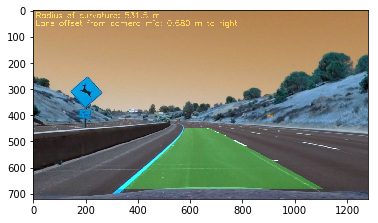

In [8]:


#image1 = cv2.imread('test_images/straight_lines1.jpg')
image1 = cv2.imread('test_images/test1.jpg')
image2 = cv2.imread('test_images/test2.jpg')
#undistorted = cal.undistortImage(image1)
#binaryimg = get_binary_image(undistorted)
#bin_warped = warp(binaryimg)

result = pipeline(image1)
result = pipeline(image1)
result = pipeline(image1)
result = pipeline(image1)
result = pipeline(image1)
result = pipeline(image1)
result = pipeline(image1)
result = pipeline(image1)
result = pipeline(image1)
result = pipeline(image2)
result = pipeline(image2)
result = pipeline(image2)
result = pipeline(image2)
result = pipeline(image2)
result = pipeline(image2)
result = pipeline(image2)
result = pipeline(image2)
result = pipeline(image2)
result = pipeline(image2)
result = pipeline(image2)
result = pipeline(image2)
#left = Line()
#right = Line()
#lines = find_lane_lines(bin_warped, left, right)
#res, color_lane = draw_lane(lines, left, right)
#find_radius_of_curvature(right)
#find_radius_of_curvature(left)

#print('Right curve: {}m Left curve: {}m'.format(right_curv, left_curv))
# warp the image back
#clr_img = unwarp(color_lane)

# Combine the result with the original image
#result = cv2.addWeighted(undistorted, 1, clr_img, 0.3, 0)

# Add info to image
#test = float("inf")
# Create a black image
#bimg = np.zeros_like(result).astype(np.uint8)
# Write some Text
#cv2.putText(bimg,'Radius of curvature: {0:0.1f} m'.format(left.radius_of_curvature),(10,30), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,0),2)
#cv2.putText(bimg,'Offset from middle: {0:0.1f} m'.format(test),(10,60), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,0),2)

#result = cv2.addWeighted(result, 1, bimg, 0.3, 0)
plt.imshow(result)




begin


/Users/gunnarthors/anaconda/envs/CarND-project4/lib/python3.5/site-packages/ipykernel/__main__.py:141: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/gunnarthors/anaconda/envs/CarND-project4/lib/python3.5/site-packages/ipykernel/__main__.py:145: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


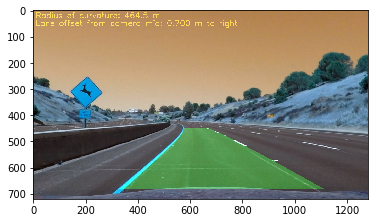

In [10]:
image1 = cv2.imread('test_images/test2.jpg')


print("begin")
result = pipeline(image1)
plt.imshow(result)
plt.savefig('testresult.png')

# VIDEO Stuff below!

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # Should send straight to solution pipeline when finished.
    # Return the image
    #img = cv2.imread(image)
    
    return pipeline(image)


In [ ]:
# Video stuff
video_output = 'vid.mp4'
clip1 = VideoFileClip('project_video.mp4')
vid_clip = clip1.fl_image(pipeline)
%time vid_clip.write_videofile(video_output, audio=False)

In [ ]:
# To view in notebook...
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))
